<a href="https://colab.research.google.com/github/RuslanMavlitov/IDE/blob/master/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22SF_mod_2_mnist_fashion_v1_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Для воспроизводимости кода установим определенную версию tensorflow и keras

In [2]:
!pip install -q tensorflow

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [4]:
print("We're using TF", tf.__version__)
print("We are using Keras", keras.__version__)

We're using TF 2.9.2
We are using Keras 2.9.0


In [5]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-6e91953c-63a6-0533-09a4-a38acd4ea260)


In [ ]:
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

Mon Apr  6 20:47:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    23W /  75W |    115MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# MNIST

In [7]:
# скачиваем данные
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [8]:
# что за данные
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[9 0 0 3 0 2 7 2 5 5]
[9 2 1 1 6 1 4 6 5 7]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


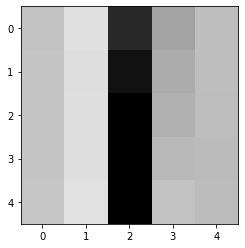

Пример картинки:


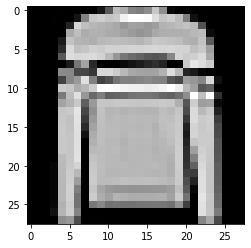

y_train [shape (60000,)] 10 примеров:
 [9 0 0 3 0 2 7 2 5 5]


In [9]:
# нарисуем картинку
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

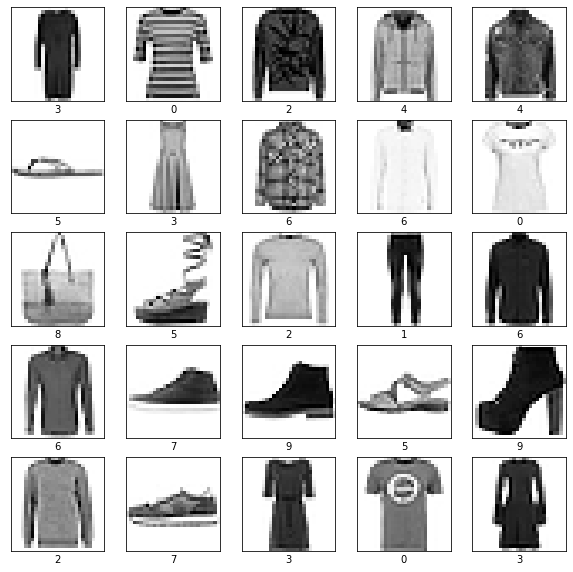

In [11]:
# Посмотрим побольше примеров
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i+25], cmap="Greys")
    plt.xlabel(y_train[i+25])
plt.show()

# Data

In [13]:
# вытянем картинку в вектор размера 28*28=784 и будем использовать это как фичи!

x_train_flat = x_train.reshape(-1, 28*28).astype(float)
print(x_train.shape, x_train_flat.shape)

x_val_flat = x_val.reshape(-1, 28*28).astype(float)
print(x_val.shape, x_val_flat.shape)

(60000, 28, 28) (60000, 784)
(10000, 28, 28) (10000, 784)


In [14]:
# центрируем и нормируем, так сети будет проще учиться
x_train_float = x_train_flat.astype(np.float) / 255 - 0.5
x_val_float = x_val_flat.astype(np.float) / 255 - 0.5

# по сути, это действия аналогичны нормализации через StandardScaler
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x_train_flat = scaler.fit_transform(x_train_flat)
# x_val_flat = scaler.transform(x_val_flat)

# Но попробуйте пропустить нормирование и посмотрите что будет ;)
# x_train_float = x_train_flat.astype(np.float)
# x_val_float = x_val_flat.astype(np.float)

<ipython-input-14-dd53c12ce9f9>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train_float = x_train_flat.astype(np.float) / 255 - 0.5
<ipython-input-14-dd53c12ce9f9>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_val_float = x_val_flat.astype(np.float) / 255 - 0.5


In [15]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [9 0 0 3 0]


# Собираем модель

Самостоятельно постойте Multi layer Perceptron (MLP) классификатор (по аналогии с практическеской частью, но на новых данных)

In [48]:
clear_session()

In [57]:
# Тут ваш код Архитектуры сети
# не забудьте 10 выходов с активацией softmax на выходном слое!
model = Sequential()
model.add(Dense(1000, activation='relu', input_shape=(28*28,))) # первый скрытый слой
model.add(Dense(500, activation='relu',))
model.add(Dense(100, activation='relu',)) # второй скрытый слой
model.add(Dense(10, activation='softmax',)) # выходной слой


In [58]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1000)              785000    
                                                                 
 dense_10 (Dense)            (None, 500)               500500    
                                                                 
 dense_11 (Dense)            (None, 100)               50100     
                                                                 
 dense_12 (Dense)            (None, 10)                1010      
                                                                 
Total params: 1,336,610
Trainable params: 1,336,610
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это :)
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [60]:
history = model.fit(
                    x_train_float, 
                    y_train_oh,
                    batch_size=64,  # 64 объекта для подсчета градиента на каждом шаге
                    epochs=10,  # 10 проходов по датасету
                    validation_data=(x_val_float, y_val_oh)
                    )

Epoch 1/10
938/938 [==============================] - 4s 4ms/step - loss: 0.4759 - accuracy: 0.8252 - val_loss: 0.4185 - val_accuracy: 0.8456
Epoch 2/10
938/938 [==============================] - 3s 3ms/step - loss: 0.3620 - accuracy: 0.8673 - val_loss: 0.3923 - val_accuracy: 0.8563
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 0.3254 - accuracy: 0.8794 - val_loss: 0.3753 - val_accuracy: 0.8645
Epoch 4/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2989 - accuracy: 0.8896 - val_loss: 0.3770 - val_accuracy: 0.8668
Epoch 5/10
938/938 [==============================] - 3s 4ms/step - loss: 0.2791 - accuracy: 0.8956 - val_loss: 0.3517 - val_accuracy: 0.8728
Epoch 6/10
938/938 [==============================] - 3s 3ms/step - loss: 0.2610 - accuracy: 0.9029 - val_loss: 0.3615 - val_accuracy: 0.8764
Epoch 7/10
938/938 [==============================] - 4s 4ms/step - loss: 0.2480 - accuracy: 0.9061 - val_loss: 0.3585 - val_accuracy: 0.8736
Epoch 

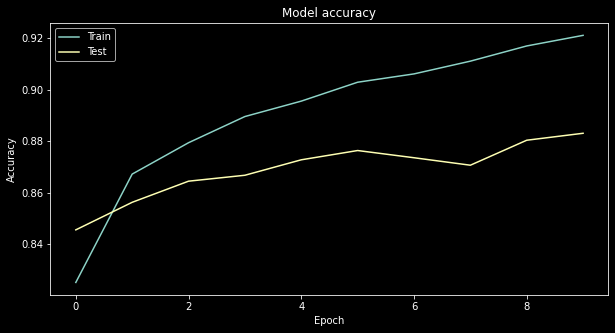

In [61]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

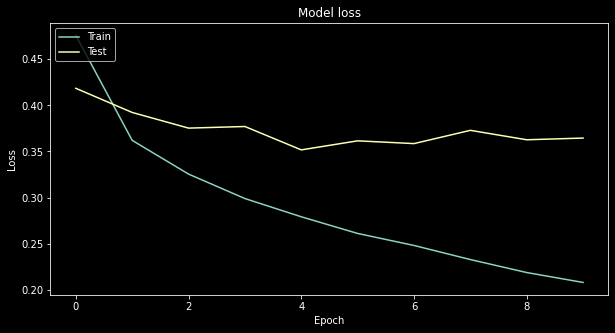

In [62]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [63]:
predicts = model.predict(x_val_float)
print('Test Accuracy: ', accuracy_score(y_val, predicts.argmax(axis=1)))

313/313 [==============================] - 1s 1ms/step
Test Accuracy:  0.8831


In [46]:
predicts.argmax().shape

(10000,)

In [45]:
y_val.shape


(10000,)

Что вам необходимо сделать:
1. Обучите сеть без скрытых слоев. (Построить аналог обычной линейной модели) **Какое accuracy на валидации получили?**
2. Обучите сеть с двумя скрытыми слоями по 128 нейронов в каждом. **Какое accuracy на валидации получили?**
3. **Сколько параметров в последней сети?**

Удачи!